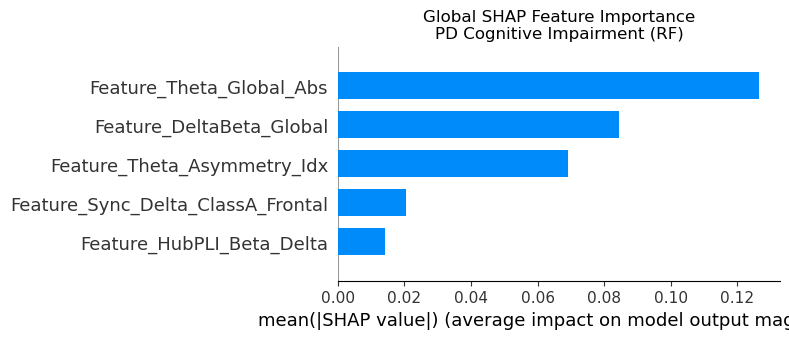

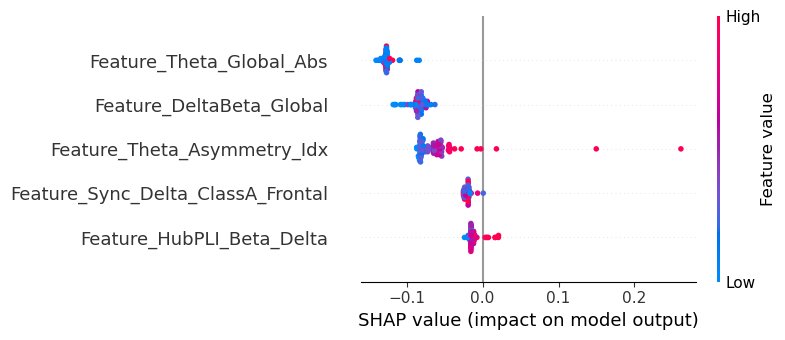

In [1]:
import shap
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# =========================
# LOAD MODEL + DATA
# =========================
model = joblib.load(
    r"C:\Users\User\Documents\EEG_Project\PD_MoCA_RF_5Feature_Final.pkl"
)

FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx'
]

df = pd.read_csv(
    r"C:\Users\User\Documents\EEG_Project\ML_Feature_Matrix.csv"
)

X = df[FEATURES]

# Extract trained RF from pipeline
rf = model.named_steps['rf']

# =========================
# SHAP EXPLAINER
# =========================
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# -------------------------
# HANDLE SHAP OUTPUT SHAPE
# -------------------------
# SHAP can return:
# 1) list of arrays (one per class)
# 2) 3D array (n_samples, n_features, n_classes)

if isinstance(shap_values, list):
    shap_vals = shap_values[0]          # class 1 = cognitively impaired
else:
    shap_vals = shap_values[:, :, 0]    # class 1

# Sanity check (critical)
assert shap_vals.shape == X.shape, (
    f"SHAP shape {shap_vals.shape} does not match X shape {X.shape}"
)

# =========================
# GLOBAL EXPLANATION (BAR)
# =========================
shap.summary_plot(
    shap_vals,
    X,
    feature_names=FEATURES,
    plot_type="bar",
    show=False
)

plt.title("Global SHAP Feature Importance\nPD Cognitive Impairment (RF)")
plt.tight_layout()
plt.show()

# =========================
# FEATURE DISTRIBUTION (BEESWARM)
# =========================
shap.summary_plot(
    shap_vals,
    X,
    feature_names=FEATURES,
    show=True
)


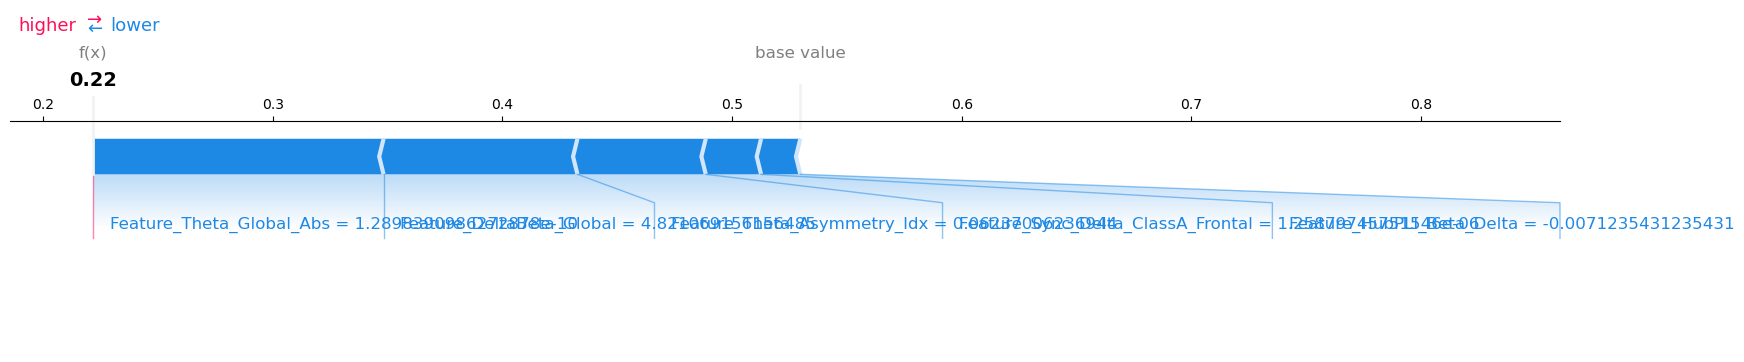

In [14]:
# Pick a subject index
idx = 2

shap.force_plot(
    explainer.expected_value[1],
    shap_vals[idx],
    X.iloc[idx],
    matplotlib=True
)


In [3]:
import shap
import matplotlib.pyplot as plt

# =========================
# PICK SUBJECT
# =========================
idx = 18

# =========================
# GET PREDICTION
# =========================
pred_prob = model.predict_proba(X[idx].reshape(1, -1))[0, 1]
pred_label = "Impaired" if pred_prob >= 0.5 else "Unimpaired"

true_label = y[idx]
true_label_name = "Impaired" if true_label == 1 else "Unimpaired"


plt.figure(figsize=(10, 5))

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],
    shap_vals[idx],
    feature_names=FEATURES,
    max_display=5
)

plt.title(
    f"Subject {idx} | Actual: {true_label_name} | "
    f"Predicted: {pred_label} (P={pred_prob:.2f})"
)

plt.tight_layout()
plt.show()

print("Predicted probability:", pred_prob)
print("True label:", true_label)


KeyError: 18

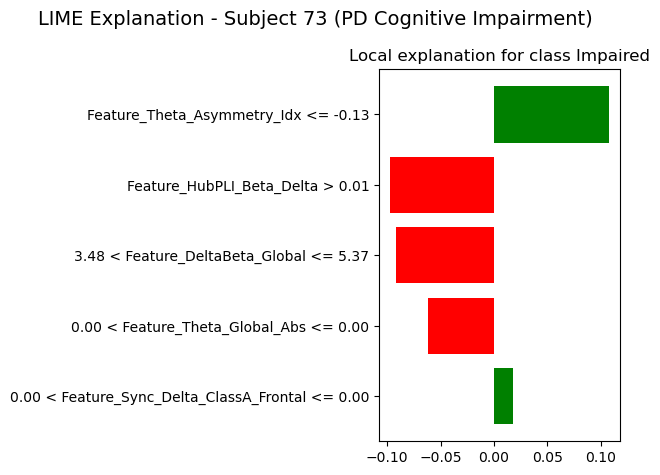

In [35]:
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# =========================
# LOAD DATA + MODEL
# =========================
model = joblib.load(r"C:\Users\User\Documents\EEG_Project\PD_MoCA_RF_5Feature_Final.pkl")

FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx'
]

df = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\ML_Feature_Matrix.csv")
X = df[FEATURES].values
y = df['Label_Impaired'].values

# Extract Random Forest from pipeline
rf = model.named_steps['rf']

# =========================
# CREATE LIME EXPLAINER
# =========================
explainer_lime = LimeTabularExplainer(
    training_data=X,
    feature_names=FEATURES,
    class_names=['Unimpaired', 'Impaired'],
    mode='classification',
    discretize_continuous=True
)

# =========================
# EXPLAIN A SINGLE SUBJECT
# =========================
idx =  73#96 # choose subject82
exp = explainer_lime.explain_instance(
    data_row=X[idx],
    predict_fn=model.predict_proba,
    num_features=5
)

# =========================
# PLOT USING MATPLOTLIB
# =========================
fig = exp.as_pyplot_figure()
fig.suptitle(f"LIME Explanation - Subject {idx} (PD Cognitive Impairment)", fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, balanced_accuracy_score
import shap

# =========================
# 1. LOAD DATA
# =========================
df = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\ML_Feature_Matrix.csv")

FEATURES = [
    'Feature_Sync_Delta_ClassA_Frontal',
    'Feature_Theta_Global_Abs',
    'Feature_HubPLI_Beta_Delta',
    'Feature_DeltaBeta_Global',
    'Feature_Theta_Asymmetry_Idx'
]

X = df[FEATURES]
y = df['Label_Impaired'].values

# =========================
# 2. SPLIT TRAIN / TEST
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================
# 3. DEFINE PIPELINE
# =========================
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # optional for RF
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
])

# =========================
# 4. CROSS-VALIDATION ON TRAINING SET
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1': make_scorer(f1_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'BalancedAcc': make_scorer(balanced_accuracy_score)
}

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring_metrics, return_train_score=False)

print("\n--- CV Performance on TRAINING SET ---")
for metric_name, scores in cv_results.items():
    if metric_name.startswith('test_'):
        print(f"{metric_name[5:]}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# =========================
# 5. TRAIN FINAL MODEL ON TRAINING SET
# =========================
pipeline.fit(X_train, y_train)

# =========================
# 6. FEATURE IMPORTANCE
# =========================
rf_model = pipeline.named_steps['rf']
importances = pd.Series(rf_model.feature_importances_, index=FEATURES).sort_values(ascending=False)
print("\n--- Feature Importances ---")
print(importances)

# =========================
# 7. PREDICTIONS ON TEST SET
# =========================
all_probs = pipeline.predict_proba(X_test)[:, 1]
all_preds = (all_probs >= 0.5).astype(int)
errors = np.where(all_preds != y_test)[0]
print(f"\nErrors on test set: {len(errors)} out of {len(y_test)}")

# =========================
# 8. SHAP EXPLAINER ON TEST SET
# =========================
explainer = shap.TreeExplainer(rf_model)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)
shap_values = explainer.shap_values(X_test_scaled)

print("\nSHAP values computed on test set.")



--- CV Performance on TRAINING SET ---
AUC: 0.739 ± 0.067
Accuracy: 0.725 ± 0.064
F1: 0.745 ± 0.036
Precision: 0.749 ± 0.087
Recall: 0.758 ± 0.084
BalancedAcc: 0.715 ± 0.074

--- Feature Importances ---
Feature_Theta_Asymmetry_Idx          0.234791
Feature_Theta_Global_Abs             0.230015
Feature_Sync_Delta_ClassA_Frontal    0.196516
Feature_HubPLI_Beta_Delta            0.171988
Feature_DeltaBeta_Global             0.166690
dtype: float64

Errors on test set: 5 out of 20

SHAP values computed on test set.


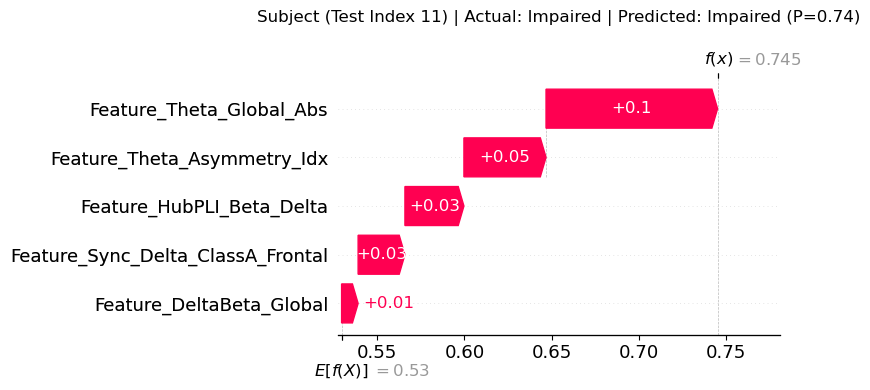

--- Analysis for Test Subject at Index 11 ---
Predicted probability of Impairment: 0.7450
True Label: 1 (Impaired)


In [18]:
# =========================
# 9. PICK SUBJECT (Individual Prediction & SHAP)
# =========================

# Choose an index from your test set (0 to len(X_test)-1)
idx = 11

# 1. Get the scaled data for this specific subject
X_test_row = X_test.iloc[[idx]]
X_test_row_scaled = pipeline.named_steps['scaler'].transform(X_test_row)

# 2. Get Prediction and Probability
# We use the pipeline directly so it handles the scaling for us
pred_prob = pipeline.predict_proba(X_test_row)[0, 1]
pred_label = "Impaired" if pred_prob >= 0.5 else "Unimpaired"

true_label = y_test[idx]
true_label_name = "Impaired" if true_label == 1 else "Unimpaired"

# 3. Handle SHAP values
# If shap_values is a list (common in older versions), we take [1] for Impaired
if isinstance(shap_values, list):
    subject_shap = shap_values[1][idx]
    base_value = explainer.expected_value[1]
else:
    # Newer versions return a 3D array [samples, features, classes]
    subject_shap = shap_values[idx, :, 1]
    base_value = explainer.expected_value[1]

# 4. Visualization
plt.figure(figsize=(10, 5))

# Using the legacy waterfall to match your requested format
shap.plots._waterfall.waterfall_legacy(
    base_value,
    subject_shap,
    feature_names=FEATURES,
    max_display=5,
    show=False # Allows us to add a title before showing
)

plt.title(
    f"Subject (Test Index {idx}) | Actual: {true_label_name} | "
    f"Predicted: {pred_label} (P={pred_prob:.2f})",
    pad=20
)

plt.tight_layout()
plt.show()

print(f"--- Analysis for Test Subject at Index {idx} ---")
print(f"Predicted probability of Impairment: {pred_prob:.4f}")
print(f"True Label: {true_label} ({true_label_name})")